# Import libraries

In [1]:
!python -m pip install scikeras

In [2]:
from scikeras.wrappers import KerasClassifier

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import KFold, GridSearchCV

In [5]:
from tensorflow.keras.models import load_model

# Download dataset

In [6]:
os.environ['KAGGLE_USERNAME'] = "samuelesimone"
os.environ['KAGGLE_KEY'] = "XXXX"

In [7]:
!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

 97% 462M/474M [00:06<00:00, 120MB/s] 
100% 474M/474M [00:06<00:00, 77.5MB/s]


In [8]:
! unzip "/content/muffin-vs-chihuahua-image-classification.zip" -d muffin-vs-chihuahua-image-classification

Output streaming troncato alle ultime 5000 righe.
  inflating: muffin-vs-chihuahua-image-classification/test/muffin/img_2_671.jpg  
  inflating: muffin-vs-chihuahua-image-classification/test/muffin/img_2_681.jpg  
  inflating: muffin-vs-chihuahua-image-classification/test/muffin/img_2_689.jpg  
  inflating: muffin-vs-chihuahua-image-classification/test/muffin/img_2_709.jpg  
  inflating: muffin-vs-chihuahua-image-classification/test/muffin/img_2_721.jpg  
  inflating: muffin-vs-chihuahua-image-classification/test/muffin/img_2_73.jpg  
  inflating: muffin-vs-chihuahua-image-classification/test/muffin/img_2_735.jpg  
  inflating: muffin-vs-chihuahua-image-classification/test/muffin/img_2_752.jpg  
  inflating: muffin-vs-chihuahua-image-classification/test/muffin/img_2_757.jpg  
  inflating: muffin-vs-chihuahua-image-classification/test/muffin/img_2_762.jpg  
  inflating: muffin-vs-chihuahua-image-classification/test/muffin/img_2_767.jpg  
  inflating: muffin-vs-chihuahua-image-classifica

# Train and test set creation

In [9]:
test_folder = '/content/muffin-vs-chihuahua-image-classification/test'
train_folder = '/content/muffin-vs-chihuahua-image-classification/train'

In [10]:
train_images = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 4733 files belonging to 2 classes.


In [11]:
test_images = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1184 files belonging to 2 classes.


# Plotting train images

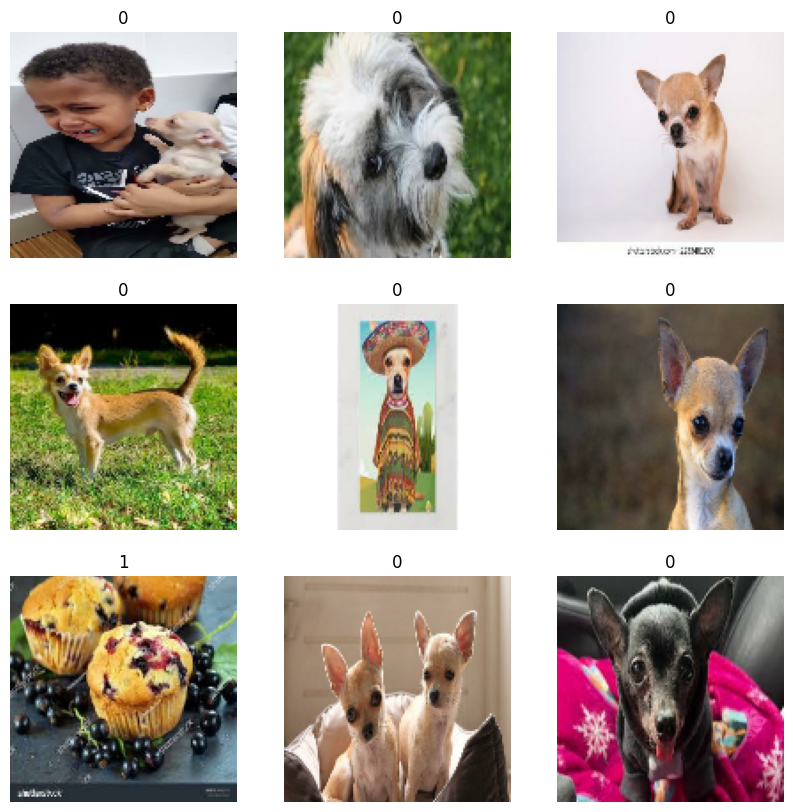

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Data augmentation

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

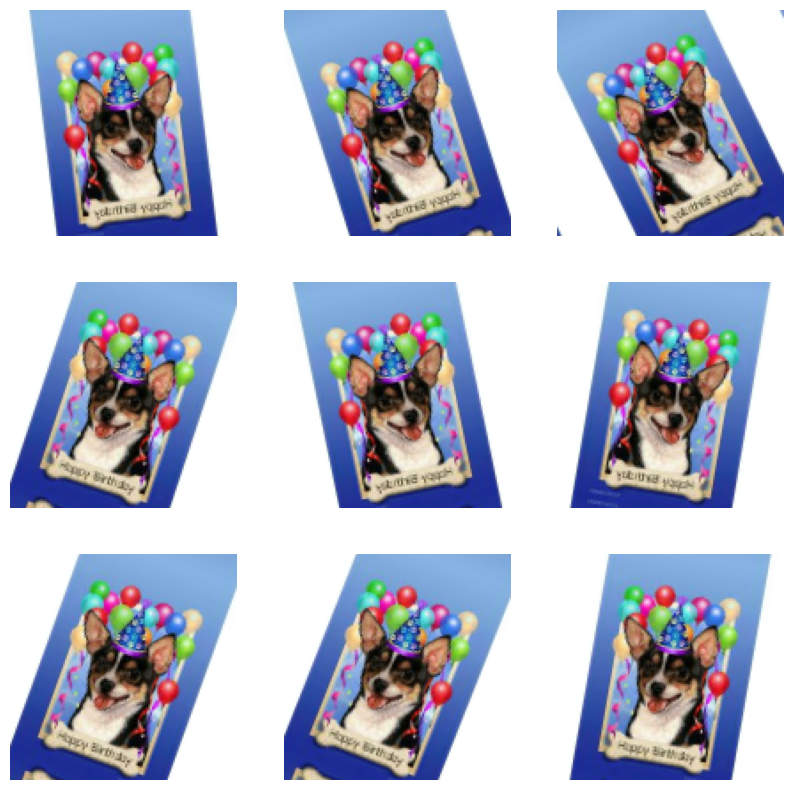

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_images.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
inputs = keras.Input(shape=(64,64))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [14]:
# Apply `data_augmentation` to the training images.
train_images = train_images.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_images = train_images.prefetch(tf.data.AUTOTUNE)

# MLP Model

In [ ]:
def make_mlp(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Flatten the 2D image into a 1D vector
    x = layers.Flatten()(inputs)

    # Dense layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    activation = 'sigmoid'
    outputs = layers.Dense(num_classes, activation=activation)(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
def zero_one_loss_func(y_true, y_pred):
    # Trasforma le probabilità predette in etichette binarie (0 o 1)
    y_pred_binary = tf.round(y_pred)

    # Confronta le etichette binarie predette con le etichette reali
    errors = tf.math.abs(y_true - y_pred_binary)

    # Calcola la zero-one loss come la media degli errori
    zero_one_loss = tf.reduce_mean(errors)

    return zero_one_loss


In [ ]:
def print_graphs(mlpname,history_per_fold_list):
  for i in range(len(history_per_fold_list)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_per_fold_list[i].history['loss'])
    plt.plot(history_per_fold_list[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)

    plt.subplot(1, 2, 2)
    plt.plot(history_per_fold_list[i].history['accuracy'])
    plt.plot(history_per_fold_list[i].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.savefig('{}_fold_{}_plot.png'.format(mlpname,i+1))
    plt.show()

In [ ]:
train_images_list = []
train_labels_list = []
for images, labels in train_images:
    train_images_list.extend(images.numpy())
    train_labels_list.extend(labels.numpy())

# Convert train_images and train_labels to NumPy arrays
train_images_list = np.array(train_images_list)
train_labels_list = np.array(train_labels_list)

# Print the shape of train_images and train_labels
print("Shape of train_images:", train_images_list.shape)
print("Shape of train_labels:", train_labels_list.shape)

Shape of train_images: (4733, 128, 128, 3)
Shape of train_labels: (4733,)


In [ ]:
# Create the MLP model for image classification
input_shape = (128, 128, 3)  # Adjust according to your image size
num_classes = 1  # Adjust based on the number of classes in your problem

In [ ]:
from sklearn.model_selection import KFold


zero_one_losses = []
try:
    # Carica il modello dal file se esiste
    model = load_model('mlp001.h5')
    print("Moded loaded successfully.")
except (OSError, IOError):
  kfold = KFold(n_splits=5, shuffle=True)
  history_per_fold_list = []

  fold_num = 1

  for train, test in kfold.split(train_images_list):
      model = make_mlp(input_shape, num_classes)

      model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=[zero_one_loss_func])

      print('------------------------------------------------------------------------')
      print(f'Training for fold {fold_num}:')

      history = model.fit(train_images_list[train], train_labels_list[train],
                          batch_size=32,
                          epochs=10,
                          validation_data=(train_images_list[test], train_labels_list[test]),  # Corrected validation data
                          verbose=1
                        )

      print()
      scores = model.evaluate(train_images_list[test], train_labels_list[test], verbose=2)  # Corrected validation data
      print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
      history_per_fold_list.append(history)

      # Calculate zero-one loss
      y_pred = model.predict(train_images_list[test])
      y_pred_classes = np.round(y_pred)
      misclassifications = np.sum(np.abs(y_pred_classes - train_labels_list[test]))
      zero_one_loss = misclassifications / len(test)
      zero_one_losses.append(zero_one_loss)
      fold_num = fold_num + 1

  model.save('mlp01.h5')

# Calculate and print the average zero-one loss
avg_zero_one_loss = np.mean(zero_one_losses)
print("Average zero-one loss:", avg_zero_one_loss)


------------------------------------------------------------------------
Training for fold 1:
Epoch 1/10
119/119 [==============================] - 32s 261ms/step - loss: 841.5640 - zero_one_loss_func: 0.4819 - val_loss: 0.7778 - val_zero_one_loss_func: 0.4574
Epoch 2/10
119/119 [==============================] - 30s 249ms/step - loss: 0.8091 - zero_one_loss_func: 0.4618 - val_loss: 0.7777 - val_zero_one_loss_func: 0.4584
Epoch 3/10
119/119 [==============================] - 36s 302ms/step - loss: 0.7503 - zero_one_loss_func: 0.4589 - val_loss: 0.7795 - val_zero_one_loss_func: 0.4584
Epoch 4/10
119/119 [==============================] - 31s 258ms/step - loss: 0.6898 - zero_one_loss_func: 0.4604 - val_loss: 0.7803 - val_zero_one_loss_func: 0.4584
Epoch 5/10
119/119 [==============================] - 30s 255ms/step - loss: 7.5421 - zero_one_loss_func: 0.4615 - val_loss: 0.7684 - val_zero_one_loss_func: 0.4564
Epoch 6/10
119/119 [==============================] - 31s 258ms/step - loss: 0.

In [ ]:
def print_graphs(mlpname,history_per_fold_list):
  for i in range(len(history_per_fold_list)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_per_fold_list[i].history['loss'])
    plt.plot(history_per_fold_list[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)

    plt.subplot(1, 2, 2)
    plt.plot(history_per_fold_list[i].history['zero_one_loss_func'])
    plt.plot(history_per_fold_list[i].history['val_zero_one_loss_func'])
    plt.ylabel('zero one loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Zero one loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.savefig('{}_fold_{}_zeroplot.png'.format(mlpname,i+1))
    plt.show()

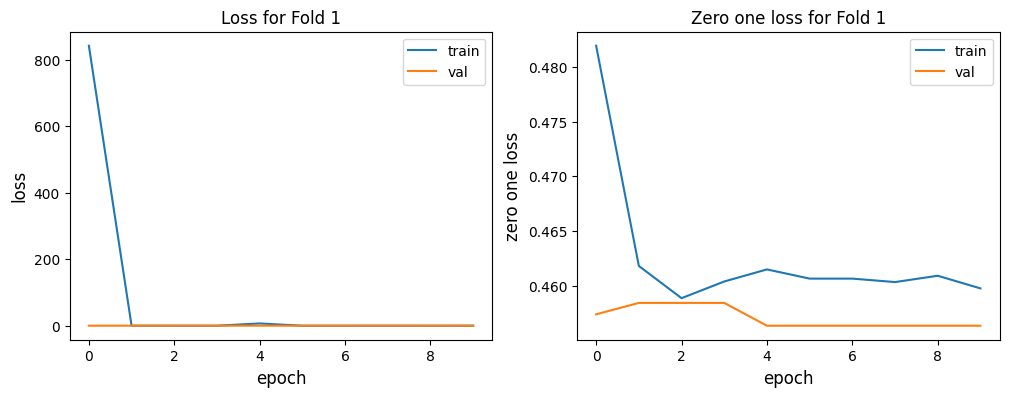

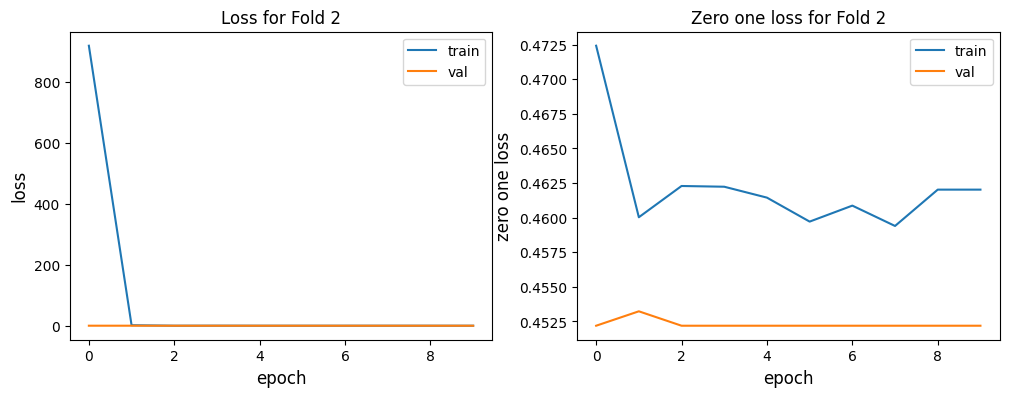

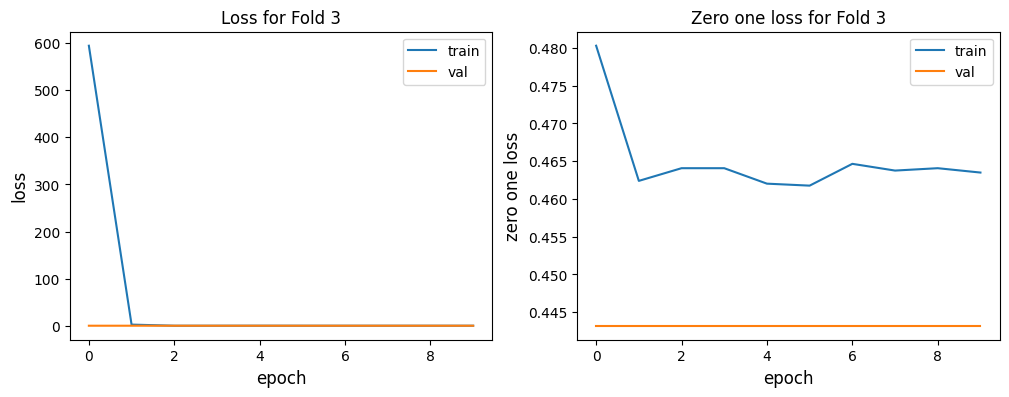

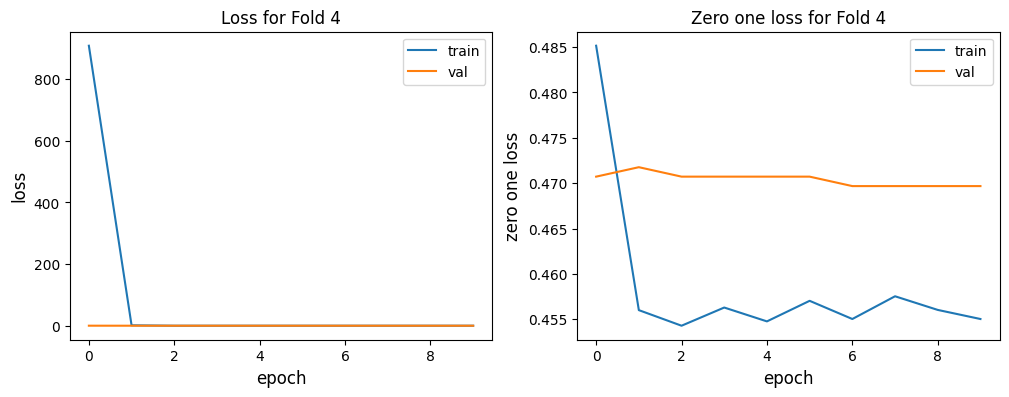

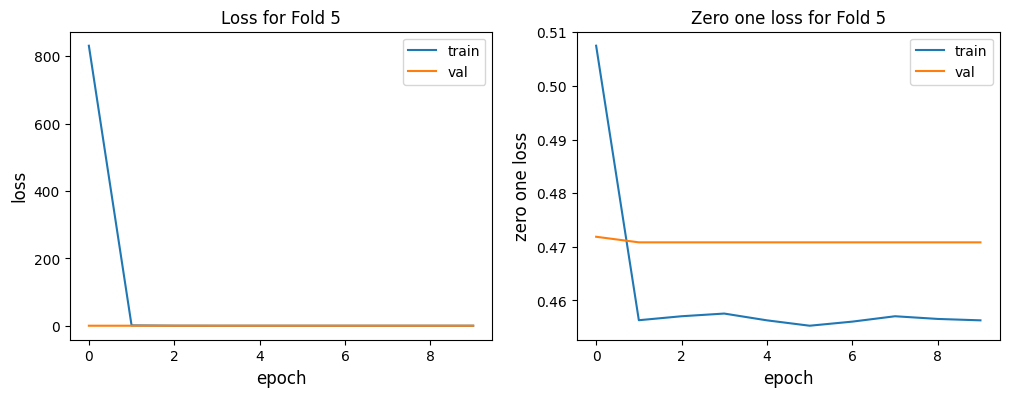

In [ ]:
print_graphs('mlp01',history_per_fold_list)

In [ ]:
# Print a summary of the model's architecture
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten_4 (Flatten)         (None, 49152)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               12583168  
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 129 

In [ ]:
print_graphs('mlp01',history_per_fold_list)

In [ ]:
del model

# Hypertuning for MLP

In [ ]:
def print_tuning_results(grid_result):
    print("Highest score is {:.4f} with {} \n".format(grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    params = grid_result.cv_results_['params']
    sorted_results = sorted(zip(means, params), reverse=True)

    print('List in descending order:')
    for mean, param in sorted_results:
        print("{:.4f} --> {} ".format(mean, param))


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Define the MLP model as a function with hyperparameters
def create_mlp_model(num_of_neurons=256, activation='relu', optimizer='adam', learning_rate=0.001):
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(128, 128, 3)),
        layers.Dense(num_of_neurons, activation=activation),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activation),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer(learning_rate),
        metrics=['accuracy']
    )

    return model



In [ ]:
# Create the parameter grid
params = {
    'optimizer': [tf.keras.optimizers.Adam],
    'learning_rate': [0.001, 0.01]
}

In [ ]:
# Wrap the MLP model with KerasClassifier
model_keras = KerasClassifier(build_fn=create_mlp_model, verbose=0)

<ipython-input-27-520e70cac3de>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_keras = KerasClassifier(build_fn=create_mlp_model, verbose=0)


In [ ]:
# Create the GridSearchCV
gridsearch = GridSearchCV(estimator=model_keras, param_grid=params, cv=5, verbose=2)

In [ ]:
# Fit the GridSearchCV to the data
gridsearch_result = gridsearch.fit(train_images_list, train_labels_list)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END learning_rate=0.001, optimizer=<class 'keras.optimizers.adam.Adam'>; total time=  33.8s
[CV] END learning_rate=0.001, optimizer=<class 'keras.optimizers.adam.Adam'>; total time=  43.4s
[CV] END learning_rate=0.001, optimizer=<class 'keras.optimizers.adam.Adam'>; total time=  55.8s
[CV] END learning_rate=0.001, optimizer=<class 'keras.optimizers.adam.Adam'>; total time=  48.0s
[CV] END learning_rate=0.001, optimizer=<class 'keras.optimizers.adam.Adam'>; total time=  45.9s
[CV] END learning_rate=0.01, optimizer=<class 'keras.optimizers.adam.Adam'>; total time=  26.9s
[CV] END learning_rate=0.01, optimizer=<class 'keras.optimizers.adam.Adam'>; total time=  45.2s
[CV] END learning_rate=0.01, optimizer=<class 'keras.optimizers.adam.Adam'>; total time=  27.2s
[CV] END learning_rate=0.01, optimizer=<class 'keras.optimizers.adam.Adam'>; total time=  45.1s
[CV] END learning_rate=0.01, optimizer=<class 'keras.optimizers.adam.Ad

In [ ]:
print_tuning_results(gridsearch_result)

Highest score is 0.5403 with {'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.adam.Adam'>} 

List in descending order:
0.5403 --> {'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.adam.Adam'>} 
0.5119 --> {'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.adam.Adam'>} 


Retrain the model with the hyperparams tuned.

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV

# Adapting the model function for the next code snippet
def create_mlp_model(num_of_neurons=256, activation='relu', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)):
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(128, 128, 3)),
        layers.Dense(num_of_neurons, activation=activation),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activation),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[zero_one_loss_func]
    )

    return model



In [ ]:
from sklearn.model_selection import KFold

try:
    # Carica il modello dal file se esiste
  model = load_model('mlp002.h5')
  print("Moded loaded successfully.")
except (OSError, IOError):
  kfold = KFold(n_splits=5, shuffle=True)
  history_per_fold_list = []
  fold_num = 1

  for train, test in kfold.split(train_images_list):
      model = create_mlp_model(num_of_neurons=256, activation='relu', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))



      print('------------------------------------------------------------------------')
      print(f'Training for fold {fold_num}:')

      history = model.fit(train_images_list[train], train_labels_list[train],
                          batch_size=32,
                          epochs=10,
                          validation_data=(train_images_list[test], train_labels_list[test]),  # Corrected validation data
                          verbose=1
                        )

      print()
      scores = model.evaluate(train_images_list[test], train_labels_list[test], verbose=2)  # Corrected validation data
      print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
      history_per_fold_list.append(history)

      fold_num = fold_num + 1
  model.save('mlp02.h5')


------------------------------------------------------------------------
Training for fold 1:
Epoch 1/10
119/119 [==============================] - 31s 250ms/step - loss: 6402.9297 - zero_one_loss_func: 0.4792 - val_loss: 0.6918 - val_zero_one_loss_func: 0.4755
Epoch 2/10
119/119 [==============================] - 29s 242ms/step - loss: 20.6926 - zero_one_loss_func: 0.4580 - val_loss: 0.6920 - val_zero_one_loss_func: 0.4755
Epoch 3/10
119/119 [==============================] - 29s 246ms/step - loss: 6.5519 - zero_one_loss_func: 0.4575 - val_loss: 0.6919 - val_zero_one_loss_func: 0.4755
Epoch 4/10
119/119 [==============================] - 29s 240ms/step - loss: 4.8472 - zero_one_loss_func: 0.4567 - val_loss: 0.6927 - val_zero_one_loss_func: 0.4755
Epoch 5/10
119/119 [==============================] - 30s 249ms/step - loss: 7.7787 - zero_one_loss_func: 0.4554 - val_loss: 0.6933 - val_zero_one_loss_func: 0.4755
Epoch 6/10
119/119 [==============================] - 29s 241ms/step - loss: 

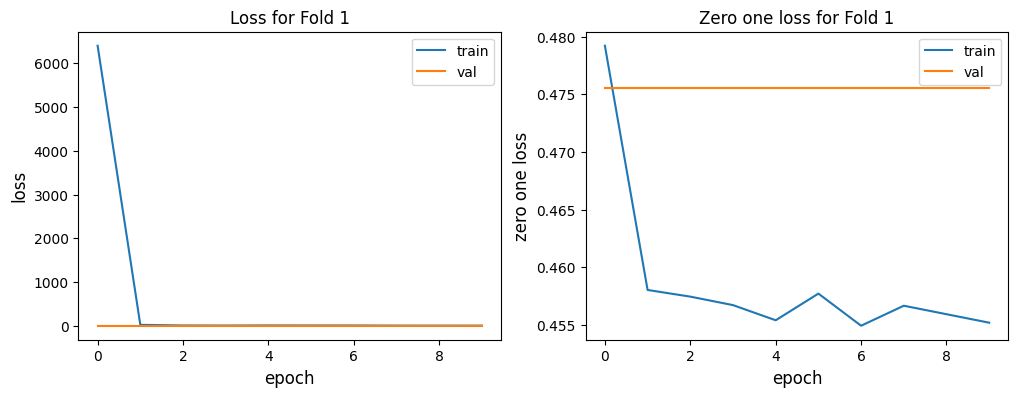

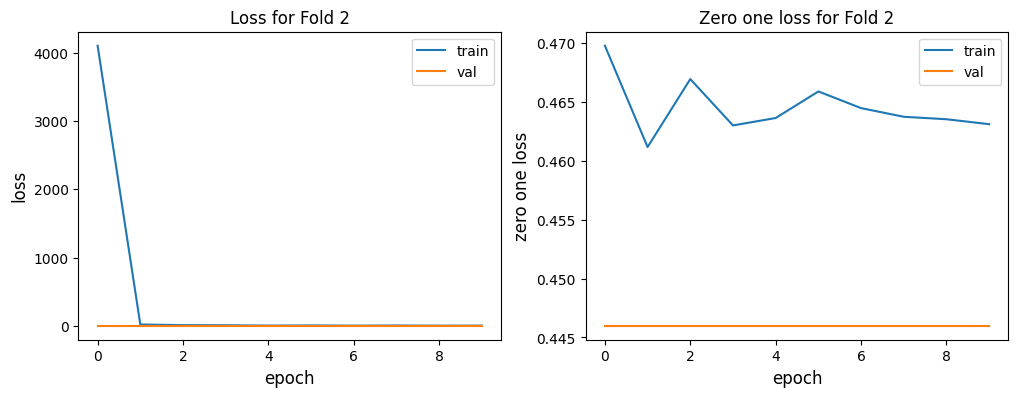

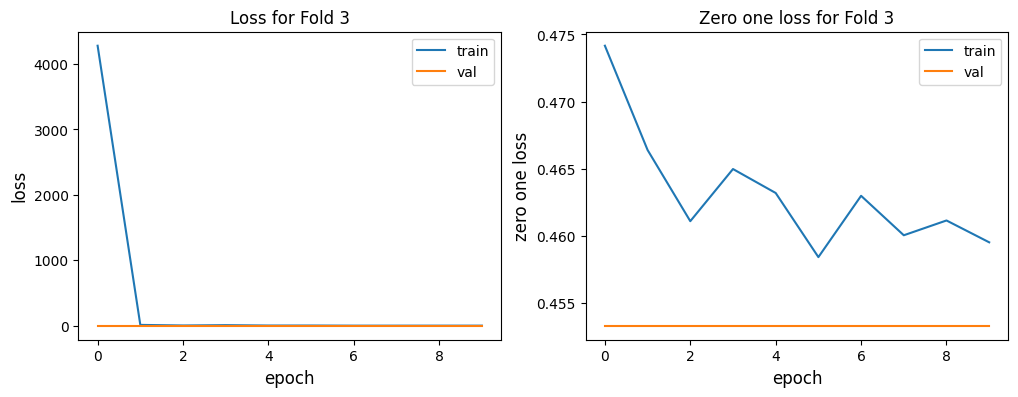

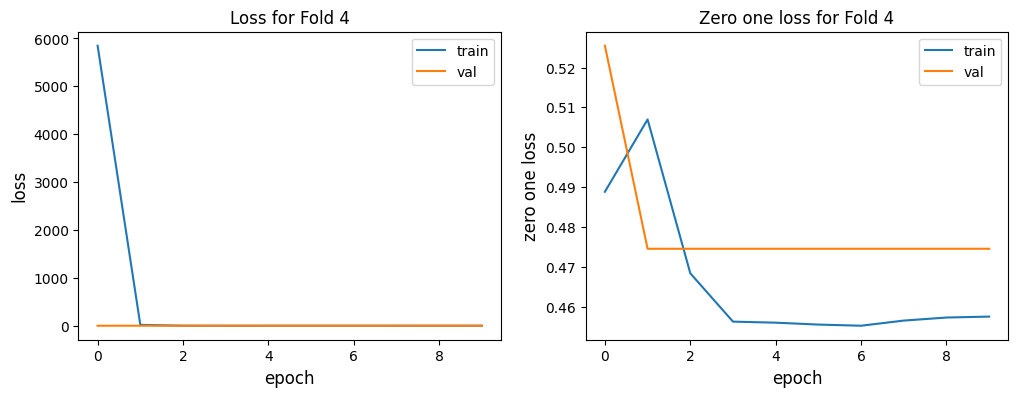

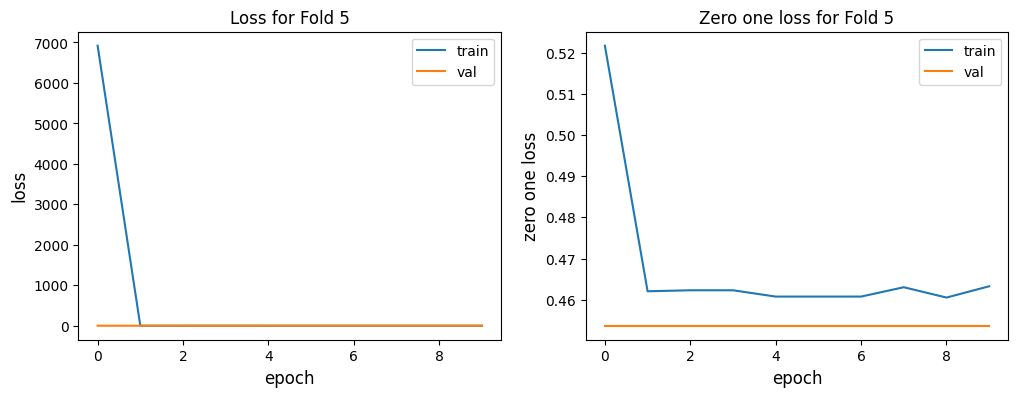

In [ ]:
print_graphs('mlp02',history_per_fold_list)

In [ ]:
del model

Added more layers

In [ ]:
from tensorflow.keras import regularizers

def make_mlp_2(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Flatten the 2D image into a 1D vector
    x = layers.Flatten()(inputs)

    # Dense layers
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    activation = 'sigmoid'
    outputs = layers.Dense(num_classes, activation=activation)(x)

    return tf.keras.Model(inputs, outputs)

# Create the MLP model for image classification
input_shape = (128, 128, 3)  # Adjust according to your image size
num_classes = 1  # Adjust based on the number of classes in your problem

model_2 = make_mlp_2(input_shape, num_classes)

# Compile the model with appropriate optimizer, loss function, and metrics
# Compile the model with appropriate optimizer, loss function, and metrics
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Print a summary of the model's architecture
model_2.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten_5 (Flatten)         (None, 49152)             0         
                                                                 
 dense_15 (Dense)            (None, 256)               12583168  
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                8256

In [ ]:
epochs = 10

model_2.fit(
    train_images,
    epochs=epochs,
)

Epoch 1/10
148/148 [==============================] - 62s 403ms/step - loss: 1083.8823 - accuracy: 0.4843
Epoch 2/10
148/148 [==============================] - 58s 383ms/step - loss: 10.3901 - accuracy: 0.5398
Epoch 3/10
148/148 [==============================] - 59s 392ms/step - loss: 9.8943 - accuracy: 0.5405
Epoch 4/10
148/148 [==============================] - 57s 379ms/step - loss: 9.4855 - accuracy: 0.5398
Epoch 5/10
148/148 [==============================] - 56s 370ms/step - loss: 9.1378 - accuracy: 0.5400
Epoch 6/10
148/148 [==============================] - 62s 414ms/step - loss: 8.7128 - accuracy: 0.5405
Epoch 7/10
148/148 [==============================] - 63s 418ms/step - loss: 8.3303 - accuracy: 0.5407
Epoch 8/10
148/148 [==============================] - 63s 421ms/step - loss: 7.9671 - accuracy: 0.5407
Epoch 9/10
148/148 [==============================] - 63s 418ms/step - loss: 7.6214 - accuracy: 0.5407


In [ ]:
from tensorflow.keras import regularizers

def make_mlp_3(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Flatten the 2D image into a 1D vector
    x = layers.Flatten()(inputs)

    # Dense layers with more neurons and different dropout rate
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    activation = 'sigmoid'
    outputs = layers.Dense(num_classes, activation=activation)(x)

    return tf.keras.Model(inputs, outputs)

# Create the MLP model for image classification
input_shape = (128, 128, 3)  # Adjust according to your image size
num_classes = 1  # Adjust based on the number of classes in your problem

model_3 = make_mlp_3(input_shape, num_classes)

# Compile the model with appropriate optimizer, loss function, and metrics
model_3.compile(optimizer='adam',
              loss='binary_crossentropy' ,
              metrics=['accuracy'])

# Print a summary of the model's architecture
model_3.summary()


In [ ]:
epochs = 10

model_3.fit(
    train_images,
    epochs=epochs,
)

# Simple Convolutional Model

In [ ]:
def make_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Middle block
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Exit block
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)


    activation = "sigmoid"

    outputs = layers.Dense(num_classes, activation=activation)(x)

    return tf.keras.Model(inputs, outputs)






In [ ]:
from sklearn.model_selection import KFold

try:
    # Carica il modello dal file se esiste
  model = load_model('cnn001.h5')
  print("Moded loaded successfully.")
except (OSError, IOError):
  kfold = KFold(n_splits=5, shuffle=True)
  history_per_fold_list = []
  zero_one_losses = []
  fold_num = 1

  for train, test in kfold.split(train_images_list):
      model = make_cnn(input_shape,num_classes)


      model.compile(
          optimizer=keras.optimizers.Adam(1e-3),
          loss="binary_crossentropy",
          metrics=[zero_one_loss_func],
      )

      print('------------------------------------------------------------------------')
      print(f'Training for fold {fold_num}:')

      history = model.fit(train_images_list[train], train_labels_list[train],
                          batch_size=32,
                          epochs=10,
                          validation_data=(train_images_list[test], train_labels_list[test]),  # Corrected validation data
                          verbose=1
                        )

      print()
      scores = model.evaluate(train_images_list[test], train_labels_list[test], verbose=2)  # Corrected validation data
      print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
      history_per_fold_list.append(history)

      # Calculate zero-one loss
      y_pred = model.predict(train_images_list[test])
      y_pred_classes = np.round(y_pred)
      misclassifications = np.sum(np.abs(y_pred_classes - train_labels_list[test]))
      zero_one_loss = misclassifications / len(test)
      zero_one_losses.append(zero_one_loss)

      fold_num = fold_num + 1
  # Calculate and print the average zero-one loss
  avg_zero_one_loss = np.mean(zero_one_losses)
  print("Average zero-one loss:", avg_zero_one_loss)
  model.save('cnn01.h5')


ValueError: ignored

In [ ]:
def print_graphs(mlpname,history_per_fold_list):
  for i in range(len(history_per_fold_list)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_per_fold_list[i].history['loss'])
    plt.plot(history_per_fold_list[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)

    plt.subplot(1, 2, 2)
    plt.plot(history_per_fold_list[i].history['zero_one_loss_func'])
    plt.plot(history_per_fold_list[i].history['val_zero_one_loss_func'])
    plt.ylabel('zero one loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Zero one loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.savefig('{}_fold_{}_zeroplot.png'.format(mlpname,i+1))
    plt.show()

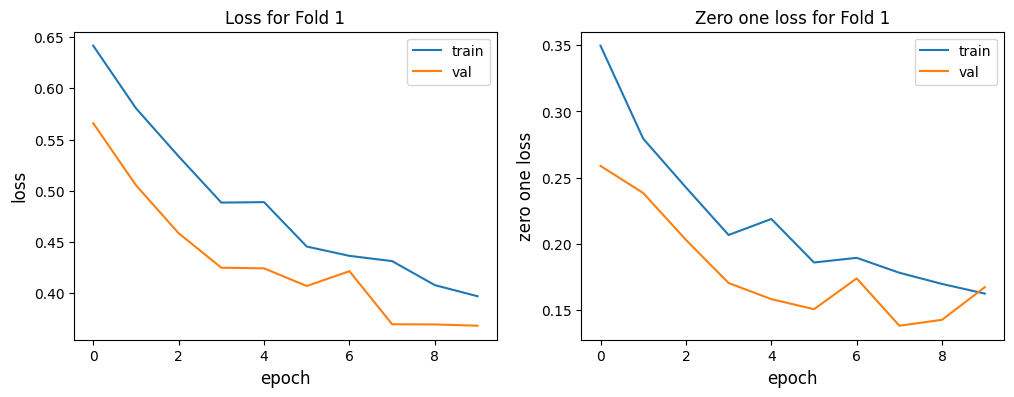

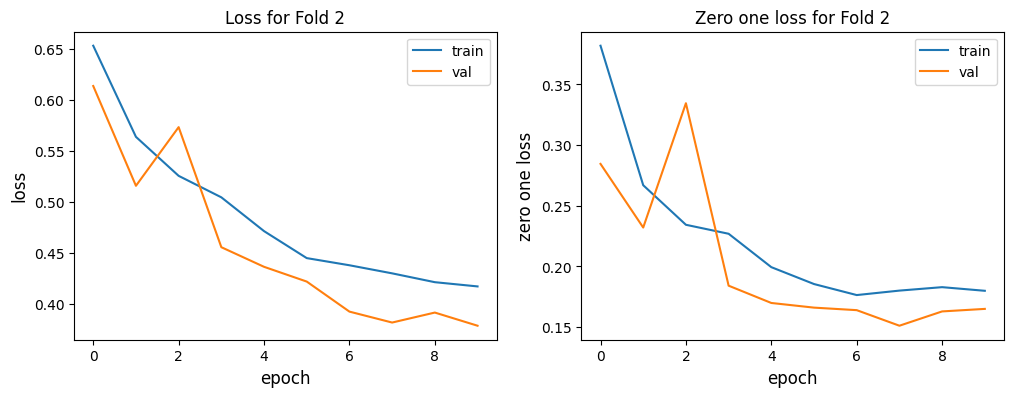

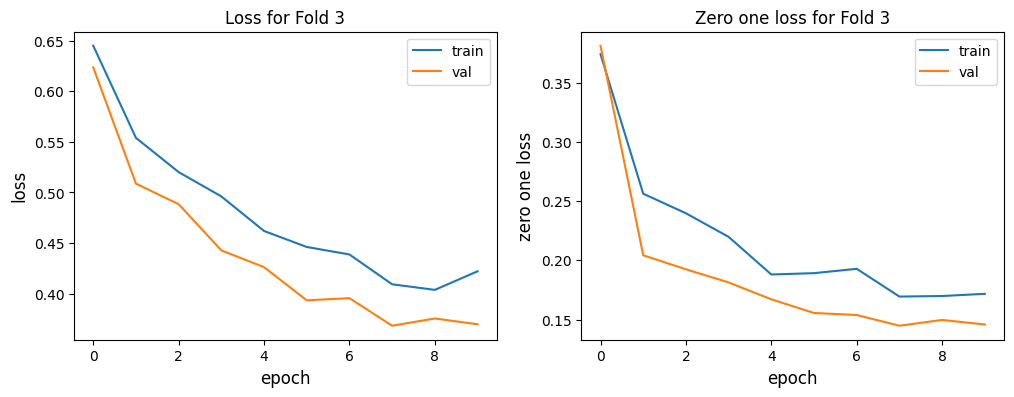

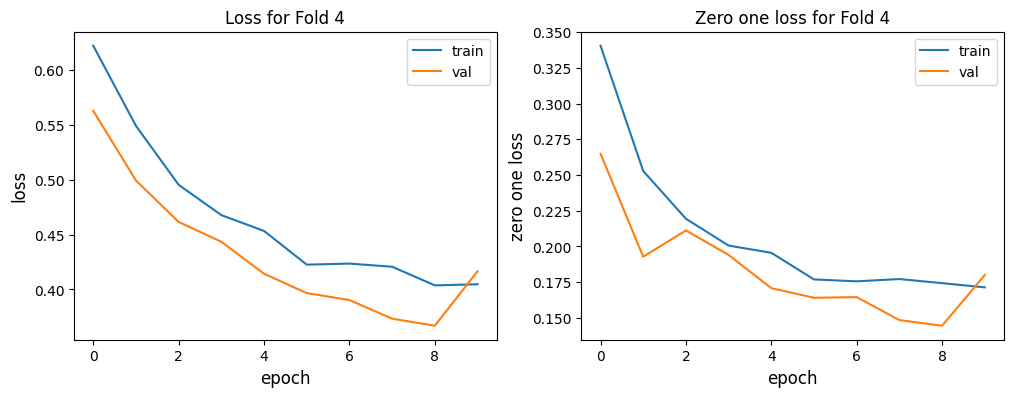

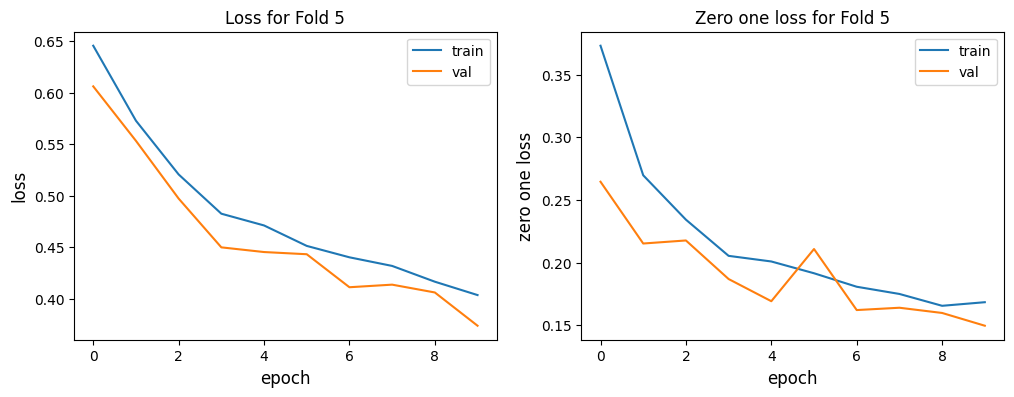

In [ ]:
print_graphs('cnn01',history_per_fold_list)

In [ ]:
# Visualize the model
tf.keras.utils.plot_model(model_simple, show_shapes=True)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model_simple.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_simple.fit(
    train_images,
    epochs=epochs,
    callbacks=callbacks
)

# Deep Residual Learning for Image Recognition: ResNet50

In [ ]:
def make_resnet50(input_shape, num_classes):

    # Carica il modello pre-addestrato ResNet50 con pesi pre-caricati da ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    # Aggiungi uno strato di Global Average Pooling e uno strato completamente connesso per la classificazione
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)

    # Componi il modello finale
    model = Model(inputs=base_model.input, outputs=predictions)

    # Congela i pesi del modello ResNet50 per evitare che vengano aggiornati durante l'addestramento
    for layer in base_model.layers:
        layer.trainable = False

    activation = "sigmoid"

    return model






In [ ]:
from sklearn.model_selection import KFold


kfold = KFold(n_splits=5, shuffle=True)
history_per_fold_list = []
zero_one_losses = []
fold_num = 1
for train, test in kfold.split(train_images_list):
      model = make_resnet50(input_shape,num_classes)


      model.compile(
          optimizer=keras.optimizers.Adam(1e-3),
          loss="binary_crossentropy",
          metrics=["accuracy"],
      )

      print('------------------------------------------------------------------------')
      print(f'Training for fold {fold_num}:')

      history = model.fit(train_images_list[train], train_labels_list[train],
                          batch_size=32,
                          epochs=10,
                          validation_data=(train_images_list[test], train_labels_list[test]),  # Corrected validation data
                          verbose=1
                        )

      print()
      scores = model.evaluate(train_images_list[test], train_labels_list[test], verbose=2)  # Corrected validation data
      print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
      history_per_fold_list.append(history)


      fold_num = fold_num + 1




------------------------------------------------------------------------
Training for fold 1:
Epoch 1/10
119/119 [==============================] - 330s 3s/step - loss: 0.1648 - accuracy: 0.9443 - val_loss: 0.0916 - val_accuracy: 0.9652
Epoch 2/10
119/119 [==============================] - 313s 3s/step - loss: 0.0697 - accuracy: 0.9762 - val_loss: 0.0911 - val_accuracy: 0.9673
Epoch 3/10
119/119 [==============================] - 291s 2s/step - loss: 0.0265 - accuracy: 0.9900 - val_loss: 0.1017 - val_accuracy: 0.9652
Epoch 4/10
119/119 [==============================] - 314s 3s/step - loss: 0.0136 - accuracy: 0.9968 - val_loss: 0.1058 - val_accuracy: 0.9715
Epoch 5/10
119/119 [==============================] - 315s 3s/step - loss: 0.0080 - accuracy: 0.9979 - val_loss: 0.1008 - val_accuracy: 0.9683
Epoch 6/10
119/119 [==============================] - 288s 2s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.1003 - val_accuracy: 0.9725
Epoch 7/10
119/119 [============================

In [ ]:
model.save('resnet50.h5')

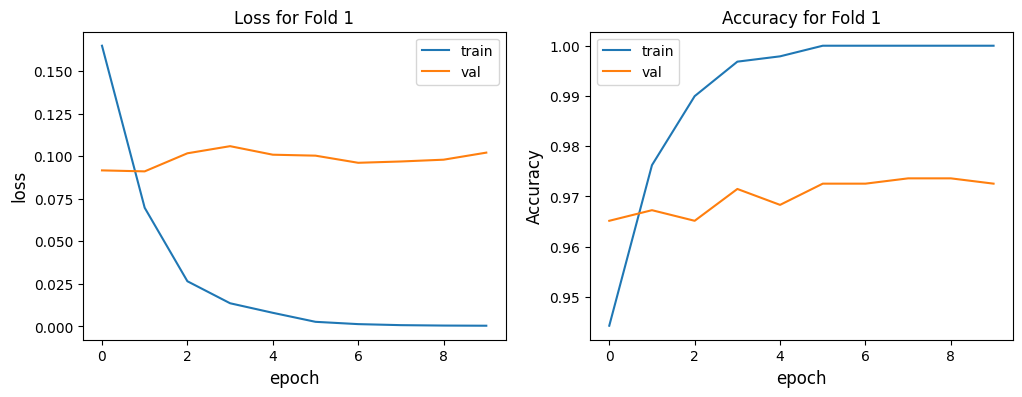

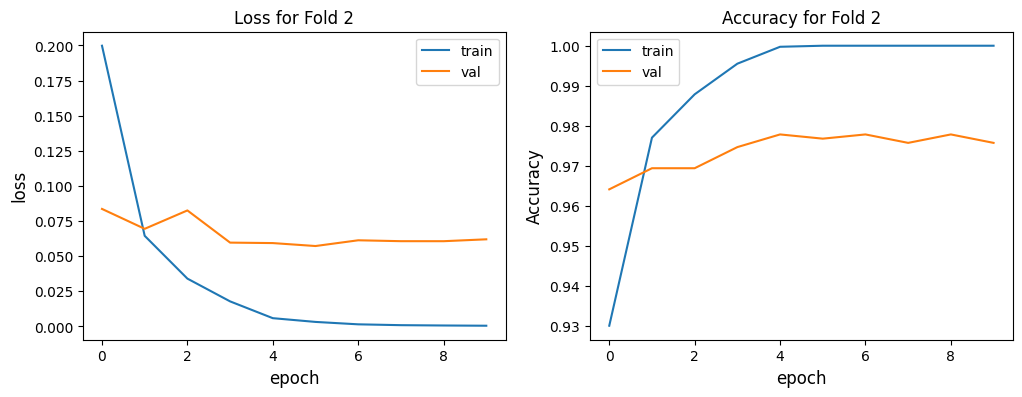

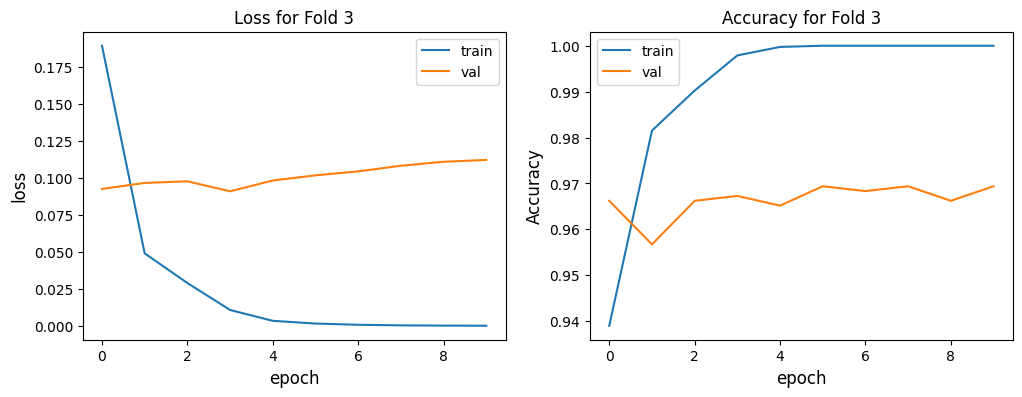

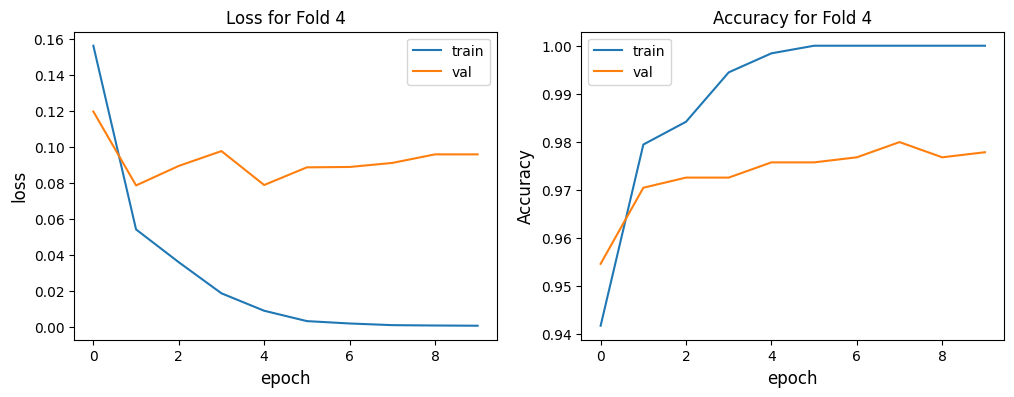

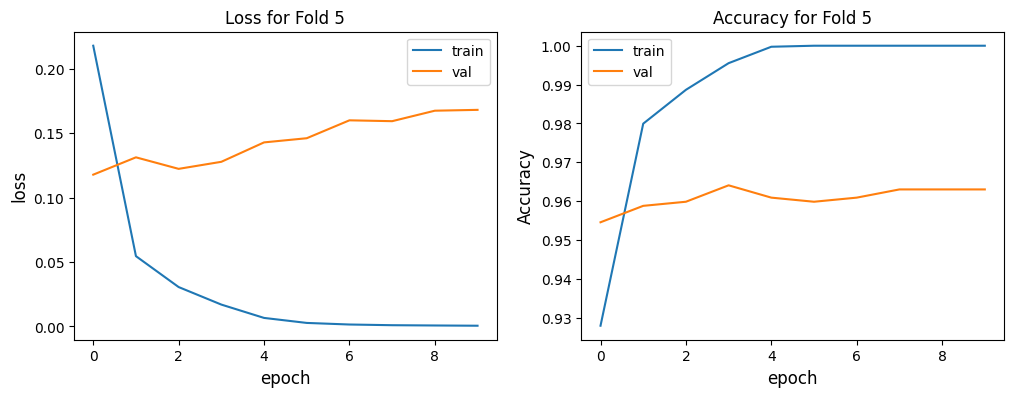

In [ ]:
print_graphs('res50',history_per_fold_list)

In [ ]:
def print_graphs(mlpname,history_per_fold_list):
  for i in range(len(history_per_fold_list)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_per_fold_list[i].history['loss'])
    plt.plot(history_per_fold_list[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)

    plt.subplot(1, 2, 2)
    plt.plot(history_per_fold_list[i].history['accuracy'])
    plt.plot(history_per_fold_list[i].history['val_accuracy'])
    plt.ylabel('Accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.savefig('{}_fold_{}_plot.png'.format(mlpname,i+1))
    plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

epochs = 10
# Carica il dataset delle immagini e le etichette (1 per muffin, 0 per chihuahua)
# Assumi che train_images_list contenga un array di immagini e train_labels_list contenga le etichette corrispondenti
# Assumi anche che le immagini abbiano dimensione 128x128x3
# Esempio di come caricare il dataset:
# train_images_list, train_labels_list = load_images_and_labels()

# Carica il modello pre-addestrato ResNet50 con pesi pre-caricati da ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

# Aggiungi uno strato di Global Average Pooling e uno strato completamente connesso per la classificazione
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Componi il modello finale
model = Model(inputs=base_model.input, outputs=predictions)

# Congela i pesi del modello ResNet50 per evitare che vengano aggiornati durante l'addestramento
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello con l'ottimizzatore Adam e la loss binary_crossentropy
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Addestra il modello sul training set
model.fit(
    train_images,
    epochs=epochs,
)

Epoch 1/10
148/148 [==============================] - 309s 2s/step - loss: 0.1743 - accuracy: 0.9398
Epoch 2/10
148/148 [==============================] - 310s 2s/step - loss: 0.0781 - accuracy: 0.9694
Epoch 3/10
148/148 [==============================] - 311s 2s/step - loss: 0.0611 - accuracy: 0.9768
Epoch 4/10
148/148 [==============================] - 311s 2s/step - loss: 0.0560 - accuracy: 0.9782
Epoch 5/10
148/148 [==============================] - 310s 2s/step - loss: 0.0442 - accuracy: 0.9846
Epoch 6/10
148/148 [==============================] - 316s 2s/step - loss: 0.0372 - accuracy: 0.9856
Epoch 7/10
148/148 [==============================] - 311s 2s/step - loss: 0.0352 - accuracy: 0.9877
Epoch 8/10
148/148 [==============================] - 313s 2s/step - loss: 0.0245 - accuracy: 0.9913
Epoch 9/10
148/148 [==============================] - 312s 2s/step - loss: 0.0185 - accuracy: 0.9935
Epoch 10/10
148/148 [==============================] - 312s 2s/step - loss: 0.0198 - accura

In [ ]:
 model.save('resnet50.h5')

# Test models

In [31]:
model_mlp01 = load_model('/content/mlp01.h5')
print("Moded loaded successfully.")

Moded loaded successfully.


In [25]:
model_mlp02 = load_model('/content/mlp02.h5')
print("Moded loaded successfully.")

Moded loaded successfully.


In [26]:
model_resnet50 = load_model('/content/resnet50.h5')
print("Moded loaded successfully.")

Moded loaded successfully.


In [27]:
model_cnn01 = load_model('/content/cnn01.h5')
print("Moded loaded successfully.")

Moded loaded successfully.


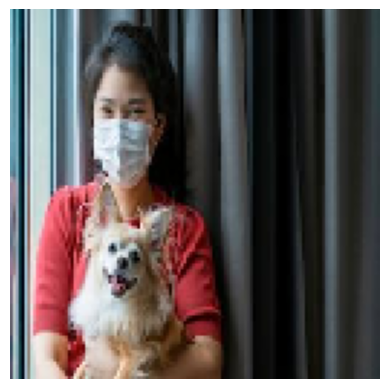

In [43]:
img = keras.utils.load_img(
    "/content/muffin-vs-chihuahua-image-classification/test/chihuahua/img_0_1071.jpg", target_size=(128,128)
)
img_array = keras.utils.img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')  # Hide axis ticks and labels
plt.show()

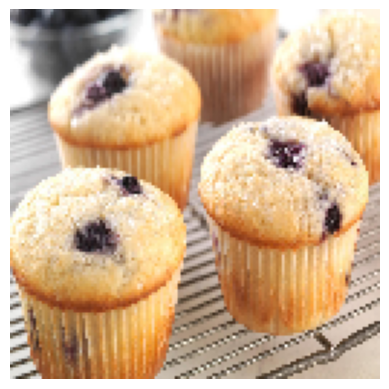

In [44]:
img = keras.utils.load_img(
    "/content/muffin-vs-chihuahua-image-classification/test/muffin/img_0_1000.jpg", target_size=(128,128)
)
img_array_muf = keras.utils.img_to_array(img)
plt.imshow(img_array_muf.astype('uint8'))
plt.axis('off')  # Hide axis ticks and labels
plt.show()

In [33]:
img_array = tf.expand_dims(img_array, 0)

In [45]:
img_array_muf = tf.expand_dims(img_array_muf, 0)

MLP 01 & MLP 02 test

In [34]:
predictions = model_mlp01.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")

1/1 [==============================] - 0s 85ms/step
This image is 54.57% chihuahua and 45.43% muffin.


In [46]:
predictions = model_mlp01.predict(img_array_muf)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")

1/1 [==============================] - 0s 143ms/step
This image is 54.57% chihuahua and 45.43% muffin.


In [35]:
loss, accuracy = model_mlp01.evaluate(test_images)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

37/37 [==============================] - 8s 166ms/step - loss: 0.6908 - accuracy: 0.5397
Test Loss: 0.6908
Test Accuracy: 0.5397


In [36]:
predictions = model_mlp02.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")

1/1 [==============================] - 0s 267ms/step
This image is 54.11% chihuahua and 45.89% muffin.


In [50]:
predictions = model_mlp02.predict(img_array_muf)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")

1/1 [==============================] - 0s 101ms/step
This image is 54.11% chihuahua and 45.89% muffin.


In [37]:
loss, accuracy = model_mlp02.evaluate(test_images)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

37/37 [==============================] - 9s 152ms/step - loss: 0.6899 - accuracy: 0.5405
Test Loss: 0.6899
Test Accuracy: 0.5405


CNN 01 test

In [38]:
predictions = model_cnn01.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")

1/1 [==============================] - 0s 132ms/step
This image is 89.93% chihuahua and 10.07% muffin.


In [49]:
predictions = model_cnn01.predict(img_array_muf)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")

1/1 [==============================] - 0s 53ms/step
This image is 1.75% chihuahua and 98.25% muffin.


In [39]:
loss, accuracy = model_cnn01.evaluate(test_images)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

37/37 [==============================] - 18s 399ms/step - loss: 0.4011 - accuracy: 0.8404
Test Loss: 0.4011
Test Accuracy: 0.8404


ResNet50 test

In [40]:
predictions = model_resnet50.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")

1/1 [==============================] - 3s 3s/step
This image is 100.00% chihuahua and 0.00% muffin.


In [51]:
predictions = model_resnet50.predict(img_array_muf)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")

1/1 [==============================] - 0s 104ms/step
This image is 0.00% chihuahua and 100.00% muffin.


In [41]:
loss, accuracy = model_resnet50.evaluate(test_images)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

37/37 [==============================] - 86s 2s/step - loss: 0.0570 - accuracy: 0.9806
Test Loss: 0.0570
Test Accuracy: 0.9806


# Training with the 5-fold cross validation

In [ ]:
import numpy as np

# Definisci il numero di fold per la cross-validation
num_folds = 5

# Definisci le dimensioni del dataset
num_samples = len(train_images)

# Genera indici casuali per la k-fold cross-validation
indices = np.random.permutation(num_samples)
fold_size = num_samples // num_folds
fold_indices = [indices[i * fold_size: (i + 1) * fold_size] for i in range(num_folds)]

# Inizializza una lista per salvare le zero-one loss di ogni fold
zero_one_losses = []

# Loop attraverso i fold
for fold in range(num_folds):
    print(f"Fold {fold + 1}/{num_folds}")

    # Seleziona gli indici per training set e validation set per questo fold
    val_indices = fold_indices[fold]
    train_indices = np.concatenate([fold_indices[i] for i in range(num_folds) if i != fold])

    # Divide il dataset in training set e validation set per questo fold
    X_train, X_val = train_images_list[train_indices], train_images_list[val_indices]
    y_train, y_val = train_labels_list[train_indices], train_labels_list[val_indices]

    # Crea il modello (sostituisci con il tuo modello preferito)
    model = make_mlp_3(input_shape=(128, 128, 3), num_classes=1)

    # Compila il modello
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Addestra il modello sul training set di questo fold
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

    # Valuta il modello sul validation set di questo fold
    y_pred = model.predict(X_val)
    y_pred_binary = np.round(y_pred)  # Converto le probabilità in predizioni binarie (0 o 1)
    zero_one_loss = np.mean(y_pred_binary != y_val)
    print(f"Fold {fold + 1} - Zero-One Loss: {zero_one_loss:.4f}")

    # Salva la zero-one loss di questo fold
    zero_one_losses.append(zero_one_loss)

# Calcola la media e la deviazione standard delle zero-one losses su tutti i fold
mean_zero_one_loss = np.mean(zero_one_losses)
std_zero_one_loss = np.std(zero_one_losses)

# Stampa i risultati finali
print(f"\nMean Zero-One Loss: {mean_zero_one_loss:.4f}")
print(f"Standard Deviation Zero-One Loss: {std_zero_one_loss:.4f}")


In [ ]:
import numpy as np

# Definisci il numero di fold per la cross-validation
num_folds = 5

# Definisci le dimensioni del dataset
num_samples = len(train_images_list)

# Genera indici casuali per la k-fold cross-validation
indices = np.random.permutation(num_samples)
fold_size = num_samples // num_folds
fold_indices = [indices[i * fold_size: (i + 1) * fold_size] for i in range(num_folds)]

# Inizializza una lista per salvare le zero-one loss di ogni fold
zero_one_losses = []

# Loop attraverso i fold
for fold in range(num_folds):
    print(f"Fold {fold + 1}/{num_folds}")

    # Seleziona gli indici per training set e validation set per questo fold
    val_indices = fold_indices[fold]
    train_indices = np.concatenate([fold_indices[i] for i in range(num_folds) if i != fold])

    # Divide il dataset in training set e validation set per questo fold
    X_train, X_val = train_images_list[train_indices], train_images_list[val_indices]
    y_train, y_val = train_labels_list[train_indices], train_labels_list[val_indices]

    # Crea il modello (sostituisci con il tuo modello preferito)
    model_simple_kfold = make_simple_model(input_shape=(128, 128, 3), num_classes=1)

    # Compila il modello
    model_simple_kfold.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Addestra il modello sul training set di questo fold
    model_simple_kfold.fit(X_train, y_train, epochs=10, batch_size=None, verbose=1)

    # Valuta il modello sul validation set di questo fold
    y_pred = model_simple_kfold.predict(X_val)
    y_pred_binary = np.round(y_pred)  # Converto le probabilità in predizioni binarie (0 o 1)
    zero_one_loss = np.mean(y_pred_binary != y_val)
    print(f"Fold {fold + 1} - Zero-One Loss: {zero_one_loss:.4f}")

    # Salva la zero-one loss di questo fold
    zero_one_losses.append(zero_one_loss)

# Calcola la media e la deviazione standard delle zero-one losses su tutti i fold
mean_zero_one_loss = np.mean(zero_one_losses)
std_zero_one_loss = np.std(zero_one_losses)

# Stampa i risultati finali
print(f"\nMean Zero-One Loss: {mean_zero_one_loss:.4f}")
print(f"Standard Deviation Zero-One Loss: {std_zero_one_loss:.4f}")
